In [1]:
import pandas

size_log = pandas.read_pickle("4-state-space-exploration-for-paper-size_log.pkl.gz")
aborts = pandas.read_pickle("4-state-space-exploration-for-paper-aborts.pkl.gz")

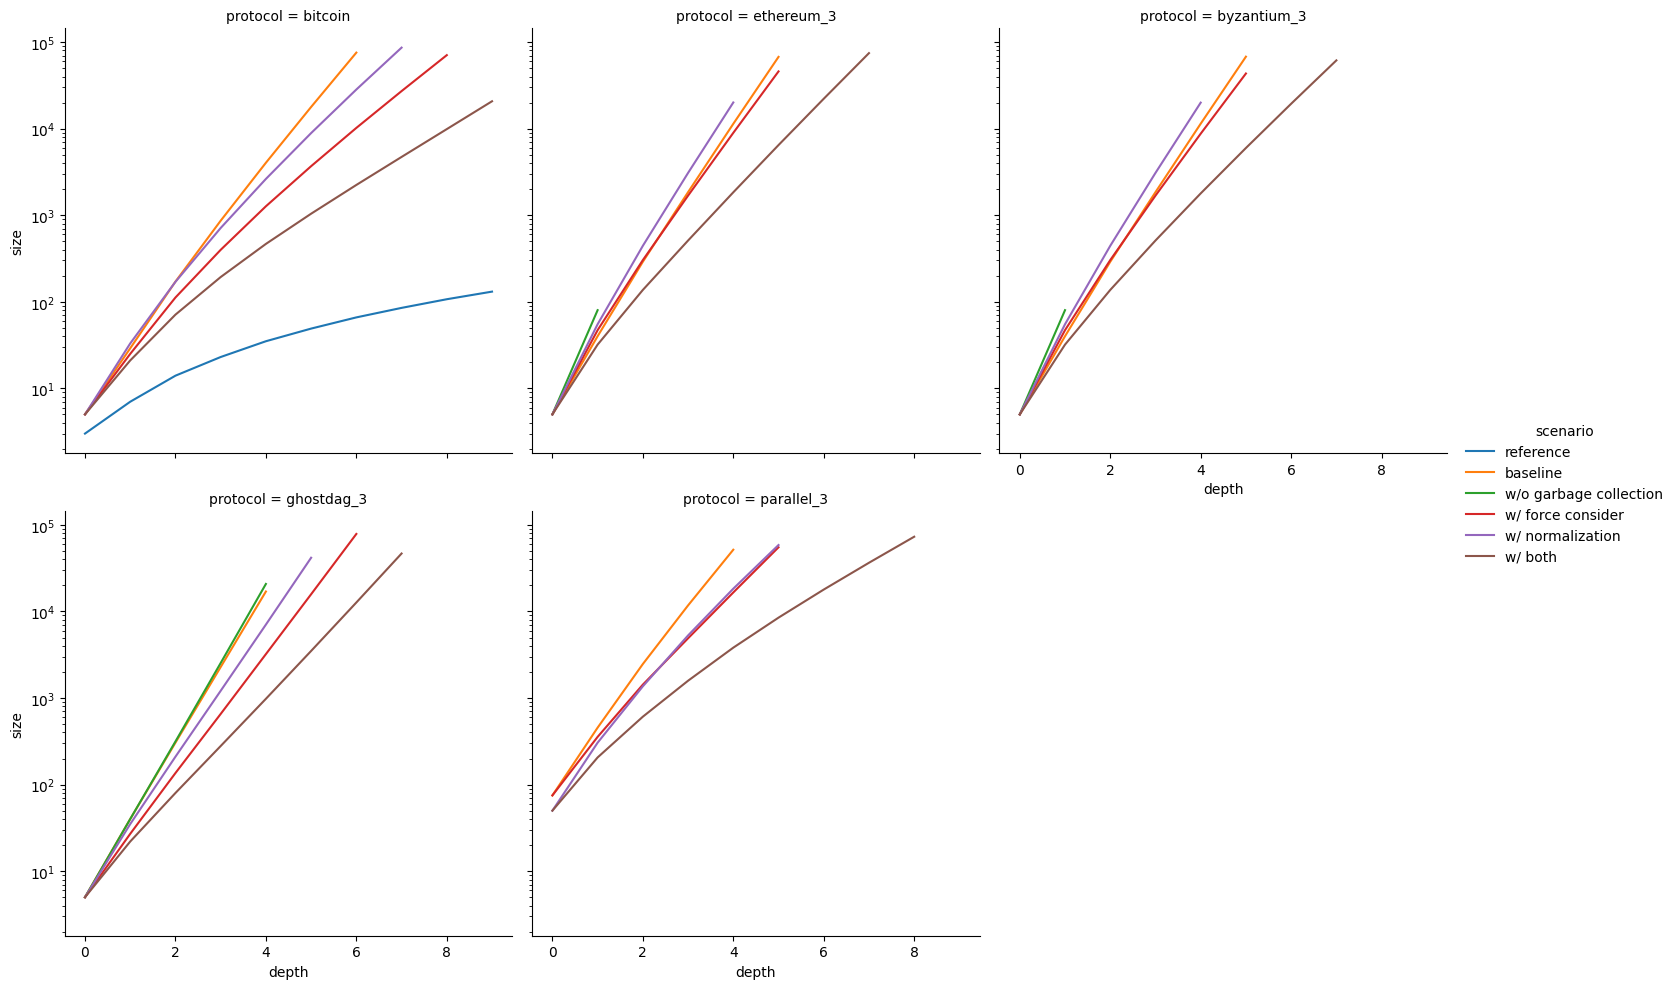

In [2]:
import seaborn

seaborn.relplot(
    data=size_log.query("depth < 10"),
    kind="line",
    x="depth",
    y="size",
    hue="scenario",
    col="protocol",
    col_wrap=3,
).set(yscale="log")

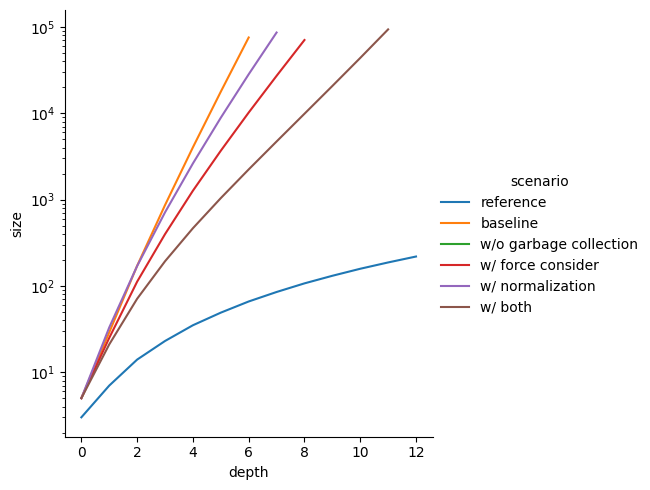

In [3]:
seaborn.relplot(
    data=size_log.query("protocol == 'bitcoin' and depth < 13"),
    kind="line",
    x="depth",
    y="size",
    hue="scenario",
).set(yscale="log")

In [4]:
scenario_labels = {
    "reference": "reference-fc16",
    "baseline": "baseline",
    "w/o garbage collection": "baseline-gc",
    "w/ force consider": "baseline+fc",
    "w/ normalization": "baseline+n",
    "w/ both": "baseline+fc+n",
}

depth_cutoff = max(size_log.query("scenario != 'reference'").depth) + 1

btc_size = (
    size_log.assign(scenario=[scenario_labels[x] for x in size_log.scenario])
    .query("protocol == 'bitcoin'")
    .query(f"depth <= {depth_cutoff}")
    .pivot(index="depth", columns="scenario", values="size")
)

btc_size.to_csv("5-state-space-exploration-viz-for-paper-btc-size.csv")
btc_size

scenario,baseline,baseline+fc,baseline+fc+n,baseline+n,baseline-gc,reference-fc16
depth,,,,,,
0,5.0,5.0,5.0,5.0,5.0,3.0
1,29.0,25.0,21.0,33.0,NaN,7.0
2,171.0,112.0,71.0,170.0,NaN,14.0
3,864.0,398.0,193.0,712.0,NaN,23.0
4,4036.0,1268.0,466.0,2625.0,NaN,35.0
5,17809.0,3685.0,1041.0,8890.0,NaN,49.0
6,75607.0,10203.0,2237.0,28325.0,NaN,66.0
7,NaN,27156.0,4713.0,86317.0,NaN,85.0
8,NaN,70684.0,9881.0,NaN,NaN,107.0


In [96]:
# how should we report on the other protocols?
# column a: show max depth explored in table for fully optimized exploration only; calculate blow up factor and add as columns


def tabulate_deepest(d):
    return d.iloc[d.groupby(["scenario", "protocol"]).depth.idxmax()]


deepest = (
    tabulate_deepest(size_log)
    .set_index(["scenario", "model", "protocol"])["depth"]
    .reset_index()
    .query("scenario != 'w/o garbage collection'")
)
deepest

,scenario,model,protocol,depth
0,baseline,generic_1,bitcoin,6
1,baseline,generic_1,byzantium_3,5
2,baseline,generic_1,ethereum_3,5
3,baseline,generic_1,ghostdag_3,4
4,baseline,generic_1,parallel_3,4
5,reference,fc16sapirshtein,bitcoin,281
6,w/ both,generic_1,bitcoin,11
7,w/ both,generic_1,byzantium_3,7
8,w/ both,generic_1,ethereum_3,7
9,w/ both,generic_1,ghostdag_3,7


In [111]:
# how should we report on the other protocols?
# column b: fix depth in table

fixed_depth = min(deepest.depth)
fixed = (
    size_log.query("scenario != 'w/o garbage collection'")
    .query(f"depth == {fixed_depth}")
    .reset_index(drop=True)
)
fixed

,scenario,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,protocol,depth,size,time_spent
0,reference,fc16sapirshtein,True,True,True,True,bitcoin,4,35,0.001255
1,baseline,generic_1,False,False,True,True,bitcoin,4,4036,1.694769
2,baseline,generic_1,False,False,True,True,ethereum_3,4,11377,5.806366
3,baseline,generic_1,False,False,True,True,byzantium_3,4,11413,12.692351
4,baseline,generic_1,False,False,True,True,ghostdag_3,4,17012,18.163538
5,baseline,generic_1,False,False,True,True,parallel_3,4,51716,33.161804
6,w/ force consider,generic_1,True,False,True,True,bitcoin,4,1268,0.518348
7,w/ force consider,generic_1,True,False,True,True,ethereum_3,4,8945,13.353187
8,w/ force consider,generic_1,True,False,True,True,byzantium_3,4,8747,6.877765
9,w/ force consider,generic_1,True,False,True,True,ghostdag_3,4,3217,9.684827


In [114]:
combined = pandas.DataFrame(
    dict(
        max_depth=deepest.set_index(["scenario", "protocol"]).depth,
        size_at_fixed_depth=fixed.set_index(["scenario", "protocol"])["size"],
    )
).reset_index()
combined

,scenario,protocol,max_depth,size_at_fixed_depth
0,baseline,bitcoin,6,4036
1,baseline,byzantium_3,5,11413
2,baseline,ethereum_3,5,11377
3,baseline,ghostdag_3,4,17012
4,baseline,parallel_3,4,51716
5,reference,bitcoin,281,35
6,w/ both,bitcoin,11,466
7,w/ both,byzantium_3,7,1786
8,w/ both,ethereum_3,7,1839
9,w/ both,ghostdag_3,7,980


In [126]:
fixed_depth

4

In [125]:
combined.set_index(["scenario", "protocol"]).unstack(level=0).stack(
    level=0, future_stack=True
).unstack(level=1)

scenario     baseline                     reference                      \
            max_depth size_at_fixed_depth max_depth size_at_fixed_depth   
protocol                                                                  
bitcoin           6.0              4036.0     281.0                35.0   
byzantium_3       5.0             11413.0       NaN                 NaN   
ethereum_3        5.0             11377.0       NaN                 NaN   
ghostdag_3        4.0             17012.0       NaN                 NaN   
parallel_3        4.0             51716.0       NaN                 NaN   

scenario      w/ both                     w/ force consider  \
            max_depth size_at_fixed_depth         max_depth   
protocol                                                      
bitcoin          11.0               466.0               8.0   
byzantium_3       7.0              1786.0               5.0   
ethereum_3        7.0              1839.0               5.0   
ghostdag_3        7.0               980.0               6.0   
parallel_3        8.0              3821.0               5.0   

scenario                        w/ normalization                      
            size_at_fixed_depth        max_depth size_at_fixed_depth  
protocol                                                              
bitcoin                  1268.0              7.0              2625.0  
byzantium_3              8747.0              4.0             19992.0  
ethereum_3               8945.0              4.0             20068.0  
ghostdag_3               3217.0              5.0              7056.0  
parallel_3              16588.0              5.0             18343.0